## 2.0 Data Modeling

In [88]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle
import re
from datetime import datetime

nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BELLA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BELLA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2.1 Data Ingestion

In [47]:
data_dir = './../data/raw/tripadvisor_reviews.csv'
df = pd.read_csv(data_dir)
df.head()

,reviewer_rating,review_date,reviewer_category,text_review
0,5.0 of 5 bubbles,Written 27 May 2023,Couples,Visited the center early of May this year afte...
1,5.0 of 5 bubbles,Written 22 May 2023,Friends,I really enjoyed visiting the sepilok oranguta...
2,4.0 of 5 bubbles,Written 13 May 2023,Couples,It’s important to know that visiting the Sepil...
3,5.0 of 5 bubbles,Written 4 May 2023,Couples,We visited Sandakan to experience nature tour...
4,1.0 of 5 bubbles,Written 3 May 2023,NaN,Had a really disappointing visit here - it had...


### 2.2 Data Processing

In [48]:
df['reviewer_rating'] = df['reviewer_rating'].str.extract(r'(\d+\.\d+)')
df['reviewer_rating'] = df['reviewer_rating'].astype(float)
df.dropna(subset=['reviewer_rating'], inplace=True)

In [49]:
df['review_date'] = df['review_date'].apply(lambda x: datetime.strptime(x, 'Written %d %B %Y').strftime('%d-%m-%Y'))

In [50]:
df['reviewer_category'] = df['reviewer_category'].fillna('Not Specify')

In [51]:
def create_sentiment(rating):
    if rating==1 or rating==2:
        return 0 # negative sentiment, change to 0 as ml model can process negative values
    elif rating==4 or rating==5:
        return 2 # positive sentiment
    else:
        return 1 # neutral sentiment
    

In [52]:
df['reviewer_sentiment'] = df['reviewer_rating'].apply(create_sentiment)

In [53]:
df.columns

Index(['reviewer_rating', 'review_date', 'reviewer_category', 'text_review',
       'reviewer_sentiment'],
      dtype='object')

### 2.3 Text Processing

In [55]:
corpus = []
lemmatizer = WordNetLemmatizer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['text_review'])
  review = review.lower().split()
  review = [lemmatizer.lemmatize(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [56]:
cv = CountVectorizer(max_features = 2500)

In [57]:
# X the text_review & y the reviewer_sentiment
X = cv.fit_transform(corpus).toarray()
y = df['reviewer_sentiment'].values

In [58]:
# checking the X & Y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3655, 2500)
y shape: (3655,)


In [59]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2558, 2500)
y train: (2558,)
X test: (1097, 2500)
y test: (1097,)


In [60]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

### 2.4 Modeling

Random Forest (RF)

In [62]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    bootstrap=False,
    class_weight='balanced'
)

In [63]:
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_split=10, n_estimators=200)

In [64]:
y_pred = model_rf.predict(X_test_scl)

In [65]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

In [66]:
# evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8541
Precision: 0.7990
Recall: 0.8541
F1 Score: 0.7999
Confusion Matrix:
[[  5   5  37]
 [  1   4 112]
 [  0   5 928]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.11      0.19        47
           1       0.29      0.03      0.06       117
           2       0.86      0.99      0.92       933

    accuracy                           0.85      1097
   macro avg       0.66      0.38      0.39      1097
weighted avg       0.80      0.85      0.80      1097



Decision Tree (DT)

In [67]:
model_dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    criterion = 'entropy'
)

In [72]:
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4)

In [73]:
y_pred = model_dt.predict(X_test_scl)

In [74]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

In [75]:
# evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8259
Precision: 0.7737
Recall: 0.8259
F1 Score: 0.7945
Confusion Matrix:
[[  4  10  33]
 [  6  12  99]
 [ 17  26 890]]

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.09      0.11        47
           1       0.25      0.10      0.15       117
           2       0.87      0.95      0.91       933

    accuracy                           0.83      1097
   macro avg       0.42      0.38      0.39      1097
weighted avg       0.77      0.83      0.79      1097



Multi-layer Perceptron (MLP)

In [82]:
model_mlp = MLPClassifier(
    hidden_layer_sizes = (100,),
    activation = 'logistic',
    solver = 'adam',
    alpha = 0.001,
    learning_rate = 'constant',
    max_iter = 200,
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 5,
    random_state = 42
)

In [83]:
model_mlp.fit(X_train_scl, y_train)

MLPClassifier(activation='logistic', alpha=0.001, early_stopping=True,
              n_iter_no_change=5, random_state=42)

In [84]:
y_pred = model_mlp.predict(X_test_scl)

In [85]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

c:\Users\BELLA\.conda\envs\nlpSen_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
# evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8505
Precision: 0.7234
Recall: 0.8505
F1 Score: 0.7818
Confusion Matrix:
[[  0   0  47]
 [  0   0 117]
 [  0   0 933]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.00      0.00      0.00       117
           2       0.85      1.00      0.92       933

    accuracy                           0.85      1097
   macro avg       0.28      0.33      0.31      1097
weighted avg       0.72      0.85      0.78      1097



c:\Users\BELLA\.conda\envs\nlpSen_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BELLA\.conda\envs\nlpSen_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\BELLA\.conda\envs\nlpSen_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

### 2.5 Comparing Model

In [87]:
rf_metrics = {
    'accuracy': 0.8541,
    'precision': 0.7990,
    'recall': 0.8541,
    'f1_score': 0.7999
}

dt_metrics = {
    'accuracy': 0.8259,
    'precision': 0.7737,
    'recall': 0.8259,
    'f1_score': 0.7945
}

mlp_metrics = {
    'accuracy': 0.8505,
    'precision': 0.7234,
    'recall': 0.8505,
    'f1_score': 0.7818
}

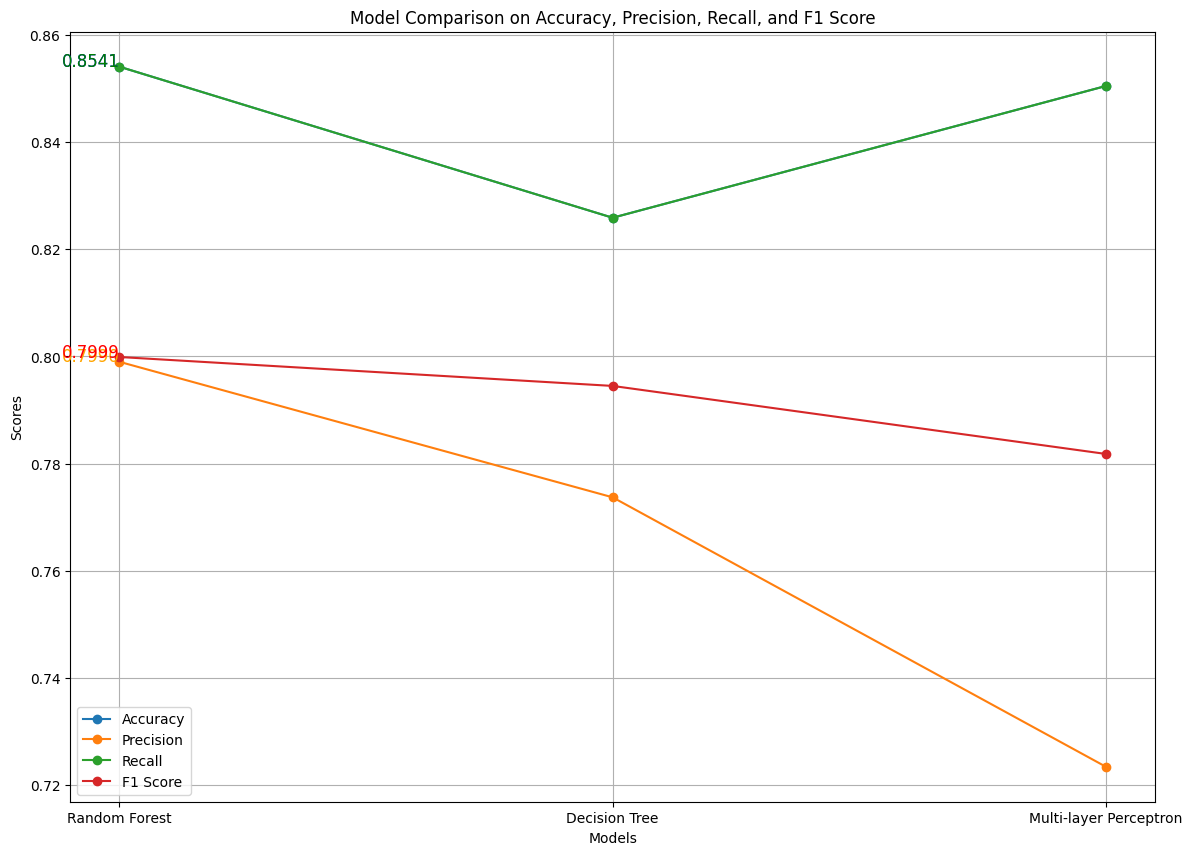

In [90]:
models = ['Random Forest', 'Decision Tree', 'Multi-layer Perceptron']
accuracy_scores = [rf_metrics['accuracy'], dt_metrics['accuracy'], mlp_metrics['accuracy']]
precision_scores = [rf_metrics['precision'], dt_metrics['precision'], mlp_metrics['precision']]
recall_scores = [rf_metrics['recall'], dt_metrics['recall'], mlp_metrics['recall']]
f1_scores = [rf_metrics['f1_score'], dt_metrics['f1_score'], mlp_metrics['f1_score']]

# Plotting
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.plot(models, accuracy_scores, marker='o', label='Accuracy')
max_accuracy_idx = accuracy_scores.index(max(accuracy_scores))
plt.text(models[max_accuracy_idx], accuracy_scores[max_accuracy_idx], 
         f'{accuracy_scores[max_accuracy_idx]:.4f}', 
         fontsize=12, ha='right', color='blue')

# Plot precision
plt.plot(models, precision_scores, marker='o', label='Precision')
max_precision_idx = precision_scores.index(max(precision_scores))
plt.text(models[max_precision_idx], precision_scores[max_precision_idx], 
         f'{precision_scores[max_precision_idx]:.4f}', 
         fontsize=12, ha='right', color='orange')

# Plot recall
plt.plot(models, recall_scores, marker='o', label='Recall')
max_recall_idx = recall_scores.index(max(recall_scores))
plt.text(models[max_recall_idx], recall_scores[max_recall_idx], 
         f'{recall_scores[max_recall_idx]:.4f}', 
         fontsize=12, ha='right', color='green')

# Plot F1 Score
plt.plot(models, f1_scores, marker='o', label='F1 Score')
max_f1_idx = f1_scores.index(max(f1_scores))
plt.text(models[max_f1_idx], f1_scores[max_f1_idx], 
         f'{f1_scores[max_f1_idx]:.4f}', 
         fontsize=12, ha='right', color='red')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison on Accuracy, Precision, Recall, and F1 Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### 2.6 Save models

In [91]:
pickle.dump(model_rf, open("./../models/model_rf.pkl", "wb")) 
pickle.dump(cv, open("./../models/cv.pkl", "wb"))  
pickle.dump(scaler, open("./../models/scaler.pkl", "wb")) 